# Cox Processes (w/ Pyro/GPyTorch Low-Level Interface)

## Introduction

This is a more in-depth example that shows off the power of the Pyro/GPyTorch low-level interface.

A Cox process is an inhomogeneous Poisson process, where the arrival rate of events (the intensity function) varies with time. We will use a GP to model this latent intensity function.

In [1]:
import math
import torch
import gpytorch
import pyro
import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

### Create sample training set

Here we're going to construct an artificial training set that follows a non-homogeneous intensity function.

#### Intensity function

We're going to assume points arrive following a sinusoidal itensity function.
This will give us points in time where there are lots of arrivals, and points in time when there are few.

In [2]:
intensity_max = 50
true_intensity_function = lambda times: torch.cos(times * 2 * math.pi).add(1).mul(intensity_max / 2.)

#### Determine how many arrivals there are

In [3]:
max_time = 2

times = torch.linspace(0, max_time, 128)
num_samples = int(pyro.distributions.Poisson(true_intensity_function(times).mean() * max_time).sample().item())
print(f"Number of sampled arrivals: {num_samples}")

Number of sampled arrivals: 48


#### Determine when the arrivals occur

We'll sample the arrivals using rejection sampling. See https://en.wikipedia.org/wiki/Poisson_point_process#Inhomogeneous_case for more details.

In [4]:
def log_prob_accept(val):
    intensities = true_intensity_function(val)
    res = torch.log(intensities / (true_intensity_function(times).mean() * max_time))
    return res

arrival_times = pyro.distributions.Rejector(
    propose=pyro.distributions.Uniform(times.min(), times.max()),
    log_prob_accept=log_prob_accept,
    log_scale=0.
)(torch.Size([num_samples]))

#### The result

Here's a plot of the intensity function and the sampled arrivals

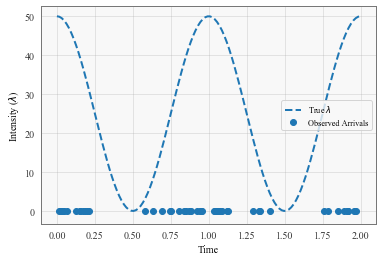

In [5]:
fig, ax = plt.subplots(1, 1)
ax.plot(times, true_intensity_function(times), "--", label=r"True $\lambda$")
ax.set_xlabel("Time")
ax.set_ylabel("Intensity ($\lambda$)")
ax.scatter(arrival_times, torch.zeros_like(arrival_times), label=r"Observed Arrivals")
ax.legend(loc="best")
None

## Parameterizing the intensity function using a GP

When using a GP to parameterize an intensity function $\lambda(t)$, we have to keep two concerns in mind:

1. The intensity function is non-negative, whereas the output of the GP can be negative
2. The intensity function can take on large values (e.g. 900), whereas GP inference works best when latent function values are fairly normal (e.g. $\mathbb{E}[f] = 0$ and $\mathbb{E}[f^2] = 1$).

As a result, we will use the following transform to convert GP latent function samples into intensity function samples:

```python
# function_samples = <samples from the GP>
# self.mean_intensity = E[ \lambda (t) ] - computed from data
intensity_samples = function_samples.exp() * self.mean_intensity
```

## The Cox process likelihood

Given an intensity function $\lambda$, the likelihood of a Cox process is

$$
\log p(t_1, \ldots, t_n | \lambda) = \left[ \sum_{i=1}^n \log \lambda( t_i ) \right] - \int_0^T \lambda(\tau) d\tau
$$

The first term, which are the arrival log intensities, is easy to compute, given the `arrival_times`:

```python
# arrival_intensity_samples = <a function involving arrival_times>
arrival_log_intensities = arrival_intensity_samples.log().sum(dim=-1)
```

The second term, which is the estimated number of arrivals, can be computed analytically.
However, it is much easier to compute this integral using quadrature.
Using a grid of `quadrature_times` evenly spaced from $0$ to $T$, we can approximate this second term:

```python
# quadrature_intensity_samples = <a function involving quadrature_times>
# max_time = T
est_num_arrivals = quadrature_intensity_samples.mean(dim=-1).mul(self.max_time)
```

Putting this together, we have

```python
log_likelihood = arrival_log_intensities - est_num_arrivals
```

## Using the low-level Pyro/GPyTorch interface

Unfortunately, this is not a likelihood function that is easily written as a GPyTorch Likelihood object.
Because of this, we will be using the low-level interface for the Pyro/GPyTorch integration.
This is the more logical choice anyways: we're simply trying to perform inference on the intensity function rather than constructing a predictive model.

Here's how it will work. We'll use a `gpytorch.models.ApproximateGP` object to model the non-homogeneous intensity function. This object needs to define 3 functions:

- `forward(times)` - which computes the prior GP mean and covariance at the supplied times.
- `guide(arrival_times, quadrature_times)` - which defines the approximate GP posterior at both arrival times and quadrature times.
- `model(arrival_times, quadrature_times)` - which does the following 3 things

  - Computes the GP prior at arrival time and quadrature times
  - Converts GP function samples into intensity function samples, using the transformation defined above.
  - Computes the likelihood of the arrivals (observations). We will use `pyro.factor` rather than a GPyTorch likelihood or a `pyro.sample` call (given that we have defined a simple function for directly computing the log likelihood).
 
Putting it all together, we have:

In [6]:
class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, num_arrivals, max_time, num_inducing=32, name_prefix="cox_gp_model"):
        self.name_prefix = name_prefix
        self.max_time = max_time
        self.mean_intensity = (num_arrivals / max_time)
        
        # Define the variational distribution and strategy of the GP
        # We will initialize the inducing points to lie on a grid from 0 to T
        inducing_points = torch.linspace(0, max_time, num_inducing).unsqueeze(-1)
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(num_inducing_points=num_inducing)
        variational_strategy = gpytorch.variational.VariationalStrategy(self, inducing_points, variational_distribution)

        # Define model
        super().__init__(variational_strategy=variational_strategy)

        # Define mean and kernel
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, times):
        mean = self.mean_module(times)
        covar = self.covar_module(times)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

    def guide(self, arrival_times, quadrature_times):
        function_distribution = self.pyro_guide(torch.cat([arrival_times, quadrature_times], -1))

        # Draw samples from q(f) at arrival_times
        # Also draw samples from q(f) at evenly-spaced points (quadrature_times)
        with pyro.plate(self.name_prefix + ".times_plate", dim=-1):
            pyro.sample(
                self.name_prefix + ".function_samples",
                function_distribution
            )

    def model(self, arrival_times, quadrature_times):
        pyro.module(self.name_prefix + ".gp", self)
        function_distribution = self.pyro_model(torch.cat([arrival_times, quadrature_times], -1))
        
        # Draw samples from p(f) at arrival times
        # Also draw samples from p(f) at evenly-spaced points (quadrature_times)
        with pyro.plate(self.name_prefix + ".times_plate", dim=-1):
            function_samples = pyro.sample(
                self.name_prefix + ".function_samples",
                function_distribution
            )
        
        ####
        # Convert function samples into intensity samples, using the function above
        ####
        intensity_samples = function_samples.exp() * self.mean_intensity
        
        # Divide the intensity samples into arrival_intensity_samples and quadrature_intensity_samples
        arrival_intensity_samples, quadrature_intensity_samples = intensity_samples.split([
            arrival_times.size(-1), quadrature_times.size(-1)
        ], dim=-1)

        ####
        # Compute the log_likelihood, using the method described above
        ####
        arrival_log_intensities = arrival_intensity_samples.log().sum(dim=-1)
        est_num_arrivals = quadrature_intensity_samples.mean(dim=-1).mul(self.max_time)
        log_likelihood = arrival_log_intensities - est_num_arrivals
        pyro.factor(self.name_prefix + ".log_likelihood", log_likelihood)

In [7]:
model = GPModel(arrival_times.numel(), max_time)

## Performing inference

We'll use Pyro to perform inference. 

### Defining the quadrature times

We'll use 128 quadrature points.

In [8]:
quadrature_times = torch.linspace(0, max_time, 64)

### The Pyro SVI inference loop

Now we'll use Pyro to perform inference.

In [9]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
num_iter = 2 if smoke_test else 200
num_particles = 1 if smoke_test else 32


def train(lr=0.01):
    optimizer = pyro.optim.Adam({"lr": lr})
    loss = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
    infer = pyro.infer.SVI(model.model, model.guide, optimizer, loss=loss)

    model.train()
    loader = tqdm.notebook.tqdm(range(num_iter))
    for i in loader:
        loss = infer.step(arrival_times, quadrature_times)
        loader.set_postfix(loss=loss)
        
train()

## Evaluate the inferred intensity function

Here we'll see how much our inferred intensity function matches the true intensity function. We'll plot the intensity function that corresponds to the GP mean, plus the intensity function at the 5th and 95th percentiles of the GP.

In [11]:
# Here's a quick helper function for getting smoothed percentile values from samples
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]
    
    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]
    
    # Smooth the samples
    kernel = torch.full((1, 1, 5), fill_value=0.2)
    percentiles_samples = [
        torch.nn.functional.conv1d(percentile_sample.view(1, 1, -1), kernel, padding=2).view(-1)
        for percentile_sample in percentile_samples
    ]
    
    return percentile_samples

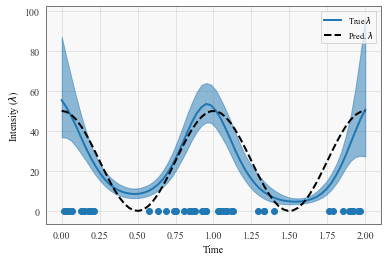

In [15]:
# Get the average predicted intensity function, and the intensity confidence region
model.eval()
with torch.no_grad():
    function_dist = model(quadrature_times)
    intensity_samples = function_dist(torch.Size([1000])).exp() * model.mean_intensity
    lower, mean, upper = percentiles_from_samples(intensity_samples)

# Plot the predicted intensity function
fig, ax = plt.subplots(1, 1)
line, = ax.plot(quadrature_times, mean, label=r"True $\lambda$")
ax.fill_between(quadrature_times, lower, upper, color=line.get_color(), alpha=0.5)
ax.plot(quadrature_times, true_intensity_function(quadrature_times), "--", color="k", label=r"Pred. $\lambda$")
ax.legend(loc="best")
ax.set_xlabel("Time")
ax.set_ylabel("Intensity ($\lambda$)")
ax.scatter(arrival_times, torch.zeros_like(arrival_times), label=r"Observed Arrivals")
None